# Deep Learning et traitement du signal TP 1 

Listez les noms des étudiants (3 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb 

- Yousef Daoud          : MVA 
- Oumniya Ramdi         : MVA
- Souhaiel Ben Salem    : MVA

Installez les paquets nécessaires à la réalisation de ce TP
<br> 
Vous pouvez utiliser dans le notebook 
!pip install \<nom_du_paquet\>
    


In [128]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt 
import scipy
import librosa 
import librosa.display
import IPython.display as ipd
from sklearn.metrics import precision_score, recall_score

## Partie 1: Audio 

### Visualisation

 Enregistrez un fichier wav de quelques secondes de votre voix. 
  <br>
 Importez le avec librosa.open et écoutez le dans le notebook avec IPython.display.Audio


In [129]:
y, sr = librosa.load("coloniedefourmies.wav")

In [130]:
ipd.Audio(data = y, rate = sr)

Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez. 

#### Forme d'onde temporelle du signal audio

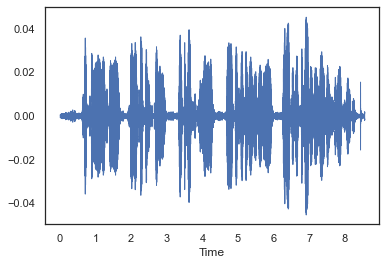

In [131]:
#Forme d'onde temporelle du signal audio
librosa.display.waveshow(y, sr=sr)

#### Densité spectrale de puissance

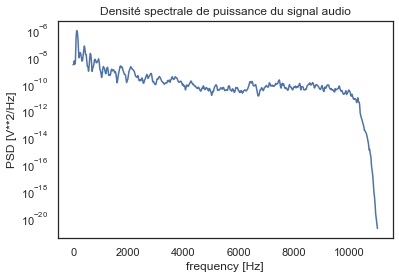

In [132]:
#Densité spectrale de puissance
from scipy import signal

def psd(y, fs):
    f, Pxx_den = signal.welch(y, fs = fs, nperseg=1024)

    plt.semilogy(f, Pxx_den)

    plt.xlabel('frequency [Hz]')

    plt.ylabel('PSD [V**2/Hz]')
    
    plt.title("Densité spectrale de puissance du signal audio") 
    
    plt.show()
    
    return f, Pxx_den

f, Pxx_den = psd(y, sr)

#### Commentaire :
En analysant les fréquences, on remarque que la variation du signal est plus marquée dans les fréquences inférieures ou égales à 10000Hz. On peut voir que la puissance est presque uniformément distribuée entre 2000 Hz et 10000 Hz. En plus, le pique de la densité spectrale de puissance appartient plutôt à la portion de fréquence des hommes [70 : 250] et plus on s'éloigne de cette partie, plus la densité spectrale diminue.

Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.

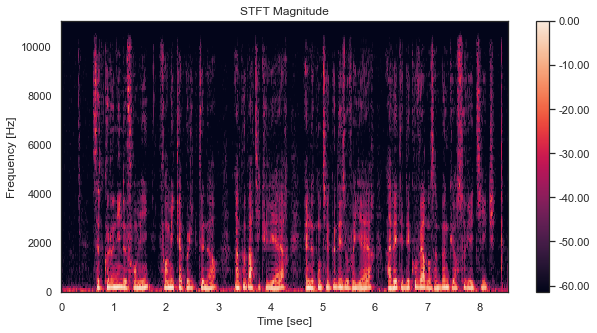

In [133]:
def show_spectrogram(y, fs = sr, nperseg = 256, noverlap = 256//2, nfft = 256, show = True):
    f, t, Zxx = scipy.signal.stft(y, fs = sr, nperseg = nperseg, noverlap = noverlap, nfft = nfft)

    S_db = librosa.amplitude_to_db(np.abs(Zxx), ref=np.max)

    fig, ax = plt.subplots(figsize=(10, 5))

    img = plt.pcolormesh(t, f, S_db)

    ax.set_title('STFT Magnitude')

    ax.set_ylabel('Frequency [Hz]')

    ax.set_xlabel('Time [sec]')

    fig.colorbar(img, ax = ax, format=f'%0.2f')
    
    if show :
        plt.show()
    
    return f, t, S_db

f, t, S_db = show_spectrogram(y)

In [134]:
def power_spectrum(signal):
    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.linspace(0,sr,len(magnitude))
    left_frequency = frequency[0:int(len(frequency)/2)]
    left_magnitude = magnitude[0:int(len(frequency)/2)]
    plt.plot(left_frequency, left_magnitude)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title("Spectre de puissance")
    plt.show()

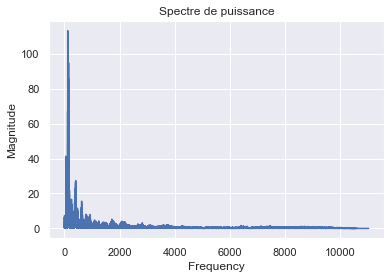

In [135]:
sns.set_theme()
power_spectrum(y)

#### Estimation visuelle du pitch:

On remarque dans le spectrogramme que le maximum d'énergie est toujours autours des basses fréquences, ce qui est logique vu que le signal audio correspond à la voix d'un homme dont la fréquence est autours de [70 : 250]. En effet, la figure ci-dessus montre que les grandes valeurs de puissances sont prises par les basses fréquences.

On remarque bien la présence des différents mots prononcés (les zones en couleur foncée). On voit que le maximum d'énergie est toujours autours des basses fréquences, ce qui est logique vu que le signal audio correspond à la voix d'un homme dont la fréquence est autours de [70 : 250].

Ainsi, nous avons choisi de régler les paramétres comme suit:

nfft: la veuleur égale à 256 correspondant au nombre des échantillons.
nperseg: corresponds à la longueur de chaque segment, cette valeur est égale à 256.
noverlap: Afin de maximiser la résolution dans le temps, ainsi que la résolution en fréquence nous avons choisi de garder la valeur égale à 256//2.

Dans cette partie du travail, l'idée est de prendre la portion où on observe un maximum d'énergie (par exemple la portion autour de 1s). Pour cette portion du temps, on extrait la fréquence qui correspond à l'énergie maximale. Ce qui est fait dans le code suivant:


In [136]:
#Une liste qu'on va remplir par les temps compris entre 1.1 secondes et 1.3 secondes (La partie où on observe le max d'énergie)
t_pitch = []
for i, tt in enumerate(t):
    if tt >= 0.4 <= 0.6:
        t_pitch.append((i, tt))

In [137]:
S_pitch = S_db[:,t_pitch[0][0]:t_pitch[-1][0] + 1] #On prend les valuers d'énergie qui correspond à cette portion temporelle

In [138]:
max_energy = [] #Cette liste sera remplie par le max d'énergie qui correspond à chaque fréquence. 
for i in range(S_pitch.shape[0]):
    max_energy.append(max(S_pitch[i]))

In [139]:
pitch = f[np.argmax(max_energy)] #On récupère la fréquence ayant le max d'énergie

In [140]:
print(f"L'estimation du pitch est : {pitch}. Ce qui appartient bien au domaine fréquentiel d'un homme.")

L'estimation du pitch est : 172.265625. Ce qui appartient bien au domaine fréquentiel d'un homme.


### Rééchantillonnage

Nous allons procéder de deux façons pour sous-échantillonner votre signal d'un facteur 2: 
- Supprimez un point sur deux: signal -> signal_reech_1
- Utilisez la fonction librosa.resample: signal -> signal_reech_2

Ecoutez les deux résultats dans le notebook et affichez le spectrogramme de (signal_reech_1 - signal) et (signal_reech_2 - signal). 

Les deux méthodes de rééchantillonnage sont elles équivalentes ? Interprétez les éventuelles différences

#### Supression d'un des deux points

In [141]:
#Supression d'un point sur deux
signal_reech_1 = y[::2]
ipd.Audio(data = signal_reech_1, rate = sr/2)

C:\Users\Youssef\AppData\Local\Temp\ipykernel_16892\2212823335.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  img = plt.pcolormesh(t, f, S_db)
C:\Users\Youssef\AppData\Local\Temp\ipykernel_16892\2212823335.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, ax = ax, format=f'%0.2f')


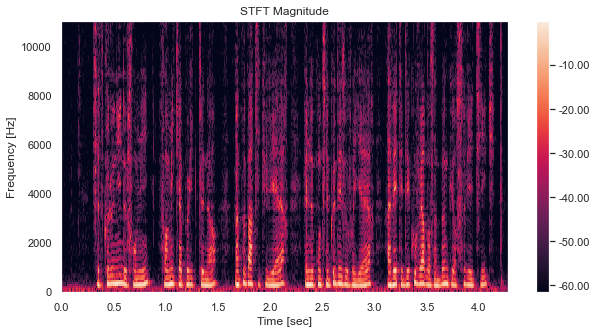

In [142]:
f, t, S_db = show_spectrogram(signal_reech_1)

#### Utilisation de la fonction librosa.resample

In [143]:
signal_reech_2 =  librosa.resample(y, orig_sr = sr, target_sr = sr/2)
ipd.Audio(data = signal_reech_2, rate = sr/2)

C:\Users\Youssef\AppData\Local\Temp\ipykernel_16892\2212823335.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  img = plt.pcolormesh(t, f, S_db)
C:\Users\Youssef\AppData\Local\Temp\ipykernel_16892\2212823335.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, ax = ax, format=f'%0.2f')


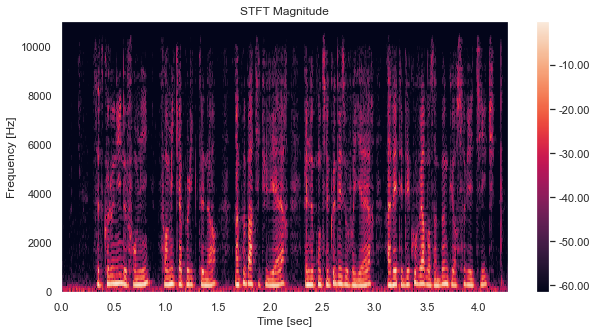

In [144]:
f, t, S_db = show_spectrogram(signal_reech_2)

Tant que les deux signaux rééchantionnés ont une taille plus petite que le signal originale donc pour pouvoir faire l'histogramme de la différences entre les deux signaux, on devra réechantionner le signal de $\frac{sr}{2}$ vers $sr$. 

In [145]:
signal_reech_1 =  librosa.resample(signal_reech_1, orig_sr = sr/2, target_sr = sr)
signal_reech_2 =  librosa.resample(signal_reech_2, orig_sr = sr/2, target_sr = sr)

In [146]:
difference_signal1 = [signal_reech_1[i] - y[i] for i in range(len(y))]
difference_signal2 = [signal_reech_2[i] - y[i] for i in range(len(y))]

#### signal_reech1 - signal

In [147]:
ipd.Audio(data = difference_signal1, rate = sr)

C:\Users\Youssef\AppData\Local\Temp\ipykernel_16892\2212823335.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  img = plt.pcolormesh(t, f, S_db)
C:\Users\Youssef\AppData\Local\Temp\ipykernel_16892\2212823335.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, ax = ax, format=f'%0.2f')


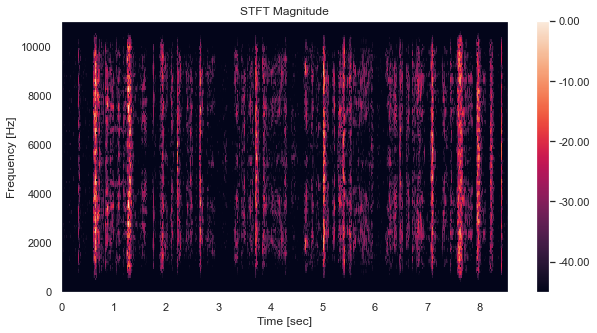

In [148]:
f, t, S_db = show_spectrogram(difference_signal1)

#### signal_reech2 - signal

In [149]:
ipd.Audio(data = difference_signal2, rate = sr)

C:\Users\Youssef\AppData\Local\Temp\ipykernel_16892\2212823335.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  img = plt.pcolormesh(t, f, S_db)
C:\Users\Youssef\AppData\Local\Temp\ipykernel_16892\2212823335.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, ax = ax, format=f'%0.2f')


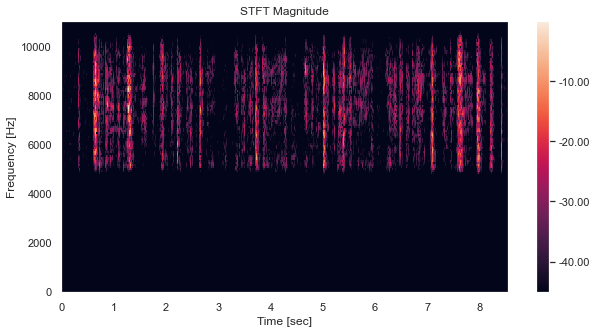

In [150]:
f, t, S_db = show_spectrogram(difference_signal2)

Dans cette partie, on a appliqué deux méthodes de réechantionnage. La première se base que sur la supression d'un point sur deux ce qui fait qu'on perds de l'information. Par contre la deuxième basée sur Librosa qui essaye de reconstruire le signal originale en utilisant une méthode de haute qualité (mais relativement lente) ("kaiser_best") pour l'interpolation sinc à bande limitée. Ainsi, d'après les spectrogrammes et les audios ci-dessus, on peut dire que la méthode de réechantionnage utilisée par Librosa permet de reproduire à peu près le même signal original pour les fréquences inférieur à 5000 Hz. Ainsi, quand on soustrait les deux signaux (signal_reech2 et signal) on pert de l'information et il ne reste que le bruit qui appartient à la bande fréquentielle 5000 Hz - 10000 Hz. Contrairement aux résultats obtenus avec la méthode de la supression d'un point sur 2.

### Calcul du Pitch

Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix.

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle. 

Commentez.

#### Réponse :

Une idée qu'on peut utilser est de parcourir chaque 20 ms dans notre signal audio est extraire la fréquence ayant un maximum d'énergie. (Presque comme fait dans la prtie 1)

In [151]:
f, t, Zxx = scipy.signal.stft(y, fs = sr, nperseg = 256, noverlap = 256//2, nfft = 256)
S_db = librosa.amplitude_to_db(np.abs(Zxx), ref=np.max)

In [152]:
frequencies = []
#On a 4 valuers de temps pour chaque 20 ms
length = len(t)/4
#On change le temps du en ms
t_ms = t*1000 
times = []
#la variable portion indique si on a extrait les 4 valeurs de temps inclut des chaque 20 ms
portion = 0
for i, tt in enumerate(t_ms):
    portion += 1
    times.append(i)
    if portion == 4: #ça veut dire qu'on est bien au bout des 20 ms => extraire la fréquence ayant le max d'énergie dans ces 20 ms
        S_pitch = S_db[:,times[0]:times[-1] + 1]
        max_energy = []
        for i in range(S_pitch.shape[0]):
            max_energy.append(max(S_pitch[i]))
        #La fréquence ayant le max d'énergie
        freq_fund = f[np.argmax(max_energy)]
        frequencies.append(freq_fund)
        portion = 0
        times = []

Text(0.5, 1.0, 'Le changement du pitch de notre signal toutes les 20 ms')

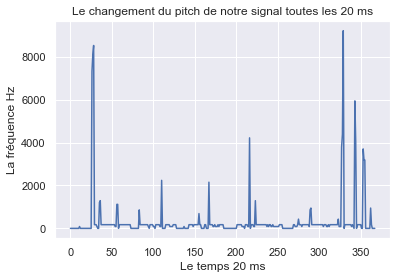

In [153]:
plt.plot(frequencies)
plt.ylabel("La fréquence Hz")
plt.xlabel("Le temps 20 ms")
plt.title("Le changement du pitch de notre signal toutes les 20 ms")

#### Commentaire:

On constate que généralement les fréquences obtenues se situes dans les basses valeurs; entre 70 et 250 Hz ce qui correspond bien au domaine fréquentiel de l'homme. Par contre, on constate qu'on a des valeurs plus basses aux alentours de 0 Hz, ce qui peut correspondre au silence qui est parfois dans l'audio. En plus, à des moments donnés on a des fréquences encore plus hautes. En effet, on sait que l'énergie des voyelles est principalement comprise entre 250 et 2000  Hz. Par contre la fréquence
des consonnes voisées (b, d, m, etc.) est comprise entre 250 - 4000 Hz. Les consonnes non voisées comme (f, s et t ..) changent considérablement et appartiennent au domaine fréquentiel 2000 - 8000 Hz. Ainsi, ça peut être la cause derrière l'obtention des hautes fréquences dans le précédente courbe.

## Partie 2: Détection d'impulsion

Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz. 

Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz. 
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon. 



In [154]:
donnees = np.load('signaux_impulsions.npz')
signaux = donnees['data']
labels = donnees['labels']

Proposez une méthode (simple) pour décider si un signal contient une impulsion ou non. Cette méthode fera intervenir un seuil. 
Utilisez votre méthode sur tous les signaux pour prédire s'ils contiennent une impulsion ou non. 

Nous allons comparer vos résultats aux résultats idéaux consignés dans le tableau labels. 

Calculez le nombre de signaux pour lesquels votre résultat concorde avec le résultat idéal. 



La précision est définie comme (le nombre de signaux décidés positifs par votre méthode et qui sont effectivement positifs)/(le nombre de signaux décidés positifs par votre méthode)

et le rappel comme (le nombre de signaux décidés positifs par votre méthode et qui sont effectivement positifs)/(le nombre de signaux réellement positifs)

Faites varier le seuil et enregistrez pour ses différentes valeurs la précision et le rappel de votre méthode. Affichez dans le plan (précision , rappel) les points de fonctionnement de votre méthode. Commentez le résultat. 

### *Analyse de données*

C:\Users\Youssef\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='labels', ylabel='count'>

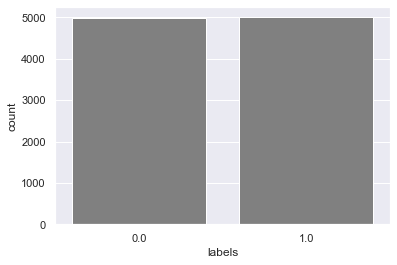

In [155]:
import seaborn as sns
sns.set()
df = pd.DataFrame({"labels" : labels})
sns.countplot(df['labels'], color='gray')

D'après la figure ci-dessus, la distribution des signaux avec impulsion est symétrique. On a 500 signaux avec impulsion et 500 signaux sans impulsion.

In [156]:
#Visualisation des labels des 10 premiers signaux
df.head(10)

,labels
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0
5,1.0
6,0.0
7,1.0
8,0.0
9,0.0


### Première idée : Exploration de la PSD de chaque genre de signal

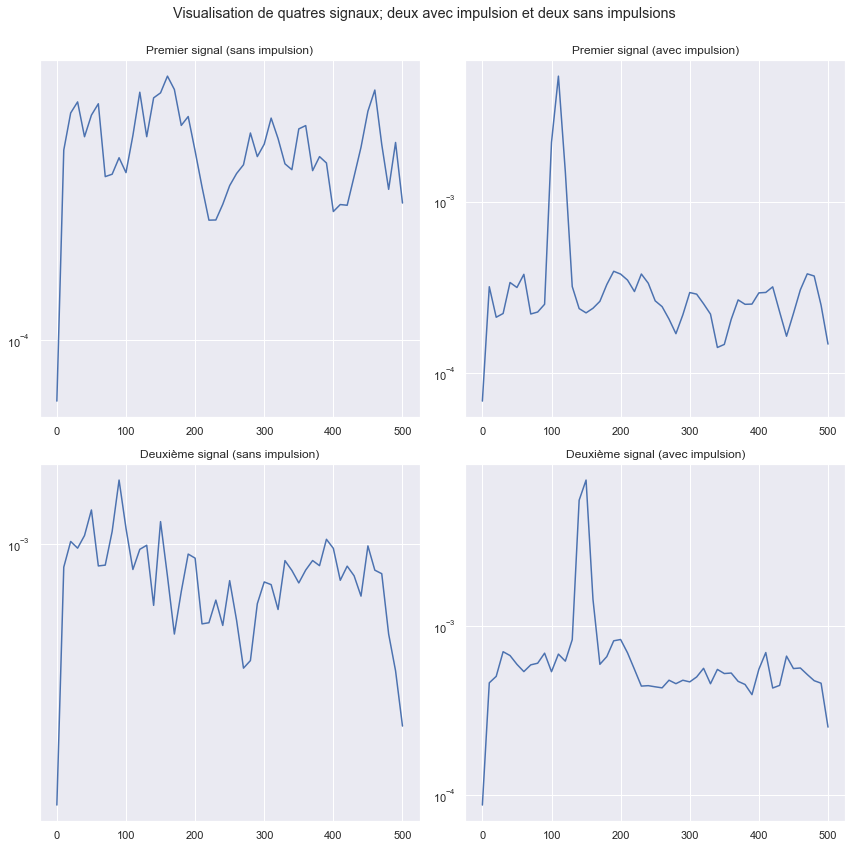

In [157]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
plt.suptitle("Visualisation de quatres signaux; deux avec impulsion et deux sans impulsions \n")
f1, Pxx_den1 = signal.welch(signaux[0], fs = 1000, nperseg=100)
axs[0, 0].semilogy(f1, Pxx_den1)
axs[0, 0].set_title("Premier signal (sans impulsion)")
f2, Pxx_den2 = signal.welch(signaux[1], fs = 1000, nperseg=100)
axs[1, 0].semilogy(f2, Pxx_den2)
axs[1, 0].set_title("Deuxième signal (sans impulsion)")
f3, Pxx_den3 = signal.welch(signaux[4], fs = 1000, nperseg=100)
axs[0, 1].semilogy(f3, Pxx_den3)
axs[0, 1].set_title("Premier signal (avec impulsion)")
f4, Pxx_den4 = signal.welch(signaux[5], fs = 1000, nperseg=100)
axs[1, 1].semilogy(f4, Pxx_den4)
axs[1, 1].set_title("Deuxième signal (avec impulsion)")
fig.tight_layout()

D'après ces figures on remarque que les signaux ayant une impulsion, contiennent un pique d'énergie dans leurs PSD, ce qui peut être un critère pour la détection des signaux avec impulsions. Pour exploiter cette remarque, on essaye de calculer le max de puissance sur la moyenne et en mettant un certain threshold, on décide si ce signal contient une impulsion ou pas.

In [158]:
max_sur_mean = [] #Une liste qui va stocker le max sur la moyenne de chaque signal
for y in signaux:
    f, Pxx_den = signal.welch(y, fs = 1000, nperseg=100)
    max_sur_mean.append(np.max(Pxx_den) / np.mean(Pxx_den))

In [159]:
def predicted_labels_threshold(threshold):
    #On considère ce signal contient une impulsion si la valeur de max_sur_mean est supérieur à un certain threshold
    predicted_labels = [1 if value >= threshold else 0 for value in max_sur_mean]
    return predicted_labels

In [160]:
#On varie la valuer des thresholds et on stocke la précision et le rappel 
thresholds = np.arange(0.5, 20, 0.1)
precisions = []
recalls = []
for th in thresholds:
    predicted = predicted_labels_threshold(th)
    precisions.append(precision_score(labels, predicted))
    recalls.append(recall_score(labels, predicted))

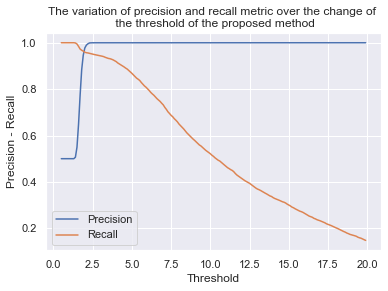

In [161]:
fig, ax = plt.subplots()
ax.plot(thresholds, precisions)
ax.plot(thresholds, recalls)
ax.set_title("The variation of precision and recall metric over the change of \n the threshold of the proposed method")
ax.set_xlabel("Threshold")
ax.set_ylabel("Precision - Recall")
ax.legend(['Precision', 'Recall'])

In [162]:
index = np.argmin(np.abs(np.array(recalls) - np.array(precisions)))
best_threshold = thresholds[index]
print(f"La meilleure valeur de threshold est {best_threshold} qui donne : \n un socre de précision : {precisions[index]} \n et un score de rappel : {recalls[index]}")

La meilleure valeur de threshold est 1.8999999999999997 qui donne : 
 un socre de précision : 0.9464285714285714 
 et un score de rappel : 0.9638289368505196


<AxesSubplot:>

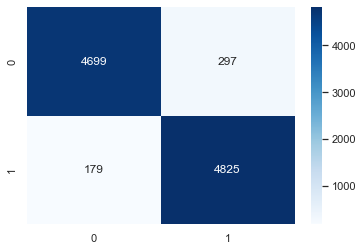

In [163]:
from sklearn.metrics import confusion_matrix
y_pred = predicted_labels_threshold(1.89)
cm = confusion_matrix(labels, y_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')

Dans notre cas, on a 4699 signaux bien classé comme "sans impulsion" mais 297 mal classé, et 4825 bien classé signaux comme avec impulsion. On peut dire que cette méthode donne des prédictions correctes équilibrées pour les deux classes (marche un plus bien pour les signaux avec impulsion 4825 > 4699).

### Deuxième idée : Exploration du spectrogramme des signaux

In [164]:
sns.set_theme(style="white")

#### Le spectrogramme d'un signal avec impulsion

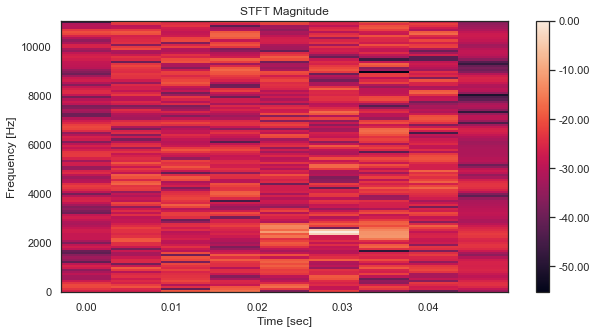

In [165]:
f, t, S_db = show_spectrogram(signaux[4], fs = 1000)

#### Le spectrogramme d'un signal sans impulsion

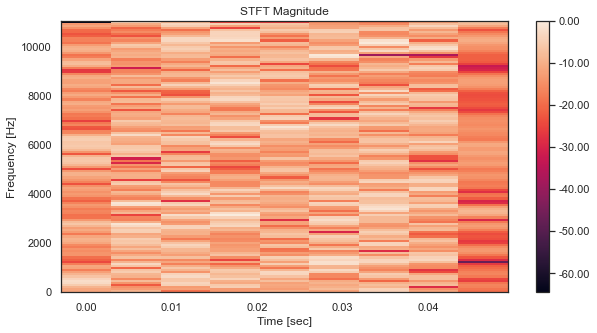

In [166]:
f, t, S_db = show_spectrogram(signaux[0], fs = 1000)

#### Commentaire :

On remarque que la distribution de l'énergie est presque uniforme pour un signal sans impulsion, par contre pour un signal avec impulsion on remarque qu'il y a une petite partie qui reçoit un maximum d'enérgie ce qui correspond bien à l'impulsion dans le signal.
Ainsi, la deuxième idée qu'on peut explorer est de calculer le nombre des piques d'énergie pour chaque signal. On mettra un threshold sur le nombre de piques. En effet, quand le signal a une impulsion donc on aura un petit nombre de piques d'énergie, par contre dans l'autre cas où la distribution d'énergie est presque uniforme on aura un grand nombre de temps - fréquence ayant un max dénergie.

In [167]:
def max_energy_signal(bound):
    #the bound of the max energy : if the energy is bigger than bound (for example -5 dB) then it's taken into consideration
    max_energy_per_signal = []
    for signal in signaux:
        f, t, Zxx = scipy.signal.stft(signal, fs = 1000, nperseg = 256, noverlap = 256//2, nfft = 256)
        S_db = librosa.amplitude_to_db(np.abs(Zxx), ref=np.max)
        max_energy = 0
        #we loop over the energies
        for S in S_db:
            for energy in S:
                if energy > bound:
                    #we upgrade the number if the energy is bigger than bound
                    max_energy += 1
        max_energy_per_signal.append(max_energy)
    #returns the number of maximal energies per signal
    return max_energy_per_signal

In [168]:
max_energy_per_signal = max_energy_signal(bound = -5)

In [169]:
def predicted_labels_threshold2(threshold):
    predicted_labels = [0 if count >= threshold else 1 for count in max_energy_per_signal]
    return predicted_labels
predicted_labels = predicted_labels_threshold(threshold = 10)

In [170]:
thresholds = np.arange(3, 1000)
precisions = []
recalls = []
for th in thresholds:
    predicted = predicted_labels_threshold2(th)
    precisions.append(precision_score(labels, predicted))
    recalls.append(recall_score(labels, predicted))

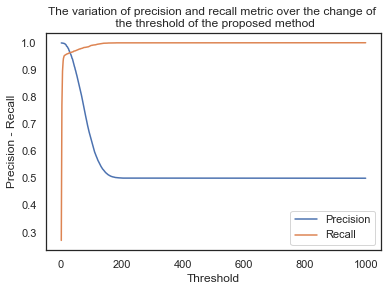

In [171]:
fig, ax = plt.subplots()
ax.plot(thresholds, precisions)
ax.plot(thresholds, recalls)
ax.set_title("The variation of precision and recall metric over the change of \n the threshold of the proposed method")
ax.set_xlabel("Threshold")
ax.set_ylabel("Precision - Recall")
ax.legend(['Precision', 'Recall'])

In [172]:
index = np.argmin(np.abs(np.array(recalls) - np.array(precisions)))
best_threshold = thresholds[index]
print(f"La meilleure valeur de threshold est {best_threshold} qui donne : \n un socre de précision : {precisions[index]} \n et un score de rappel : {recalls[index]}")

La meilleure valeur de threshold est 32 qui donne : 
 un socre de précision : 0.9615154536390828 
 et un score de rappel : 0.9636290967226219


<AxesSubplot:>

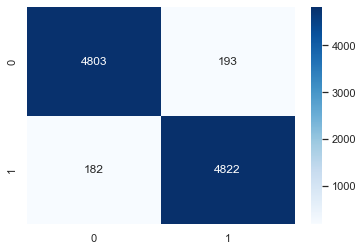

In [173]:
y_pred = predicted_labels_threshold2(32)
cm = confusion_matrix(labels, y_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')

Dans notre cas, on a 4803 signaux bien classé comme "sans impulsion" mais 193 mal classé, et 4822 bien classé signaux comme avec impulsion. On peut dire que cette méthode donne des prédictions correctes équilibrées pour les deux classes. Cette méthode est un peu plus performante par rapport à l'autre.